In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stringr)
library(ggplot2)

In [ ]:
## https://drive.google.com/file/d/16Jq6w_KAWwI2rBN7SYBw-7bm5qwVoFyt/view?usp=drive_link
seu_obj <- readRDS(file="/project/zhuzhuzhang/lyang/scaleBio_RNA_rat_brain/out_mRatBN/merged_seurat_obj_celltype_annotated_2.rds")

### Perform DEG analysis

In [29]:
# pseudobulk the counts based on donor-condition-celltype
pseudo_seu <- AggregateExpression(seu_obj, 
                                  assays = "RNA", 
                                  return.seurat = T, 
                                  group.by = c("sample_name","celltype"),
                                 normalization.method = NULL)

tail(Cells(pseudo_seu))

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.


[1] "soc-M-3_Pvalb-Inh" "soc-M-3_ASC"       "soc-M-3_ODC"      
[4] "soc-M-3_OPC"       "soc-M-3_Endo"      "soc-M-3_STR"

In [30]:
pseudo_seu

An object of class Seurat 
26597 features across 175 samples within 1 assay 
Active assay: RNA (26597 features, 0 variable features)
 2 layers present: counts, data

In [31]:
pseudo_seu$celltype.group <- 
    paste(pseudo_seu$celltype, str_split(pseudo_seu$sample_name,"-",simplify = T)[,1], sep = "_")

In [32]:
head(pseudo_seu@meta.data)

,orig.ident,sample_name,celltype,celltype.group
,<chr>,<chr>,<chr>,<chr>
iso-F-1_L2/3 IT,iso-F-1_L2/3 IT,iso-F-1,L2/3 IT,L2/3 IT_iso
iso-F-1_L4 IT,iso-F-1_L4 IT,iso-F-1,L4 IT,L4 IT_iso
iso-F-1_L5 IT,iso-F-1_L5 IT,iso-F-1,L5 IT,L5 IT_iso
iso-F-1_L6 IT,iso-F-1_L6 IT,iso-F-1,L6 IT,L6 IT_iso
iso-F-1_L5/6 NP,iso-F-1_L5/6 NP,iso-F-1,L5/6 NP,L5/6 NP_iso
iso-F-1_L6 CT,iso-F-1_L6 CT,iso-F-1,L6 CT,L6 CT_iso


In [33]:
saveRDS(pseudo_seu,file = "./pseudo_Seu_obj_2.rds")

In [35]:
Idents(pseudo_seu) <- "celltype.group"

In [36]:
pseudo_de <- list()

In [ ]:
bulk.L5IT.de.L5IT <- FindMarkers(object = pseudo_seu, 
                         ident.1 = "L5 IT_iso", 
                         ident.2 = "L5 IT_soc",
                         test.use = "DESeq2")

In [38]:
head(bulk.L5IT.de.L5IT)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Slit2,2.949433e-10,0.6359687,1,1,7.844608e-06
Samd5,7.635090e-09,-0.6475878,1,1,2.030705e-04
LOC102548918,2.099395e-07,-0.8479969,1,1,5.583761e-03
Hecw2,2.247698e-07,0.3547454,1,1,5.978203e-03
Npas2,3.742395e-07,-0.3196543,1,1,9.953649e-03
Thrb,8.550333e-07,-0.3182722,1,1,2.274132e-02


In [ ]:
pseudo_de <- list()
for(i in unique(pseudo_seu$celltype)){
    bulk.de <- FindMarkers(object = pseudo_seu,
                              ident.1 = paste0(i,"_iso"),
                              ident.2 = paste0(i,"_soc"),
                               test.use = "DESeq2")
    
    pseudo_de[[i]] <- bulk.de
}

In [43]:
names(pseudo_de)

[1] "L2/3 IT"   "L4 IT"     "L5 IT"     "L6 IT"     "L5/6 NP"   "L6 CT"    
 [7] "L5 ET"     "CGE-Inh"   "Sst-Inh"   "Pvalb-Inh" "ASC"       "ODC"      
[13] "OPC"       "Endo"

STR is missing from the DEG analysis, since it's missing in some samples

In [44]:
sapply(pseudo_de,nrow)

L2/3 IT     L4 IT     L5 IT     L6 IT   L5/6 NP     L6 CT     L5 ET   CGE-Inh 
    25760     24656     24447     25525     21544     24828     24419     21304 
  Sst-Inh Pvalb-Inh       ASC       ODC       OPC      Endo 
    22659     23400     21558     19982     23623     17601

#### plot the gene numbers that are detected in each cell type

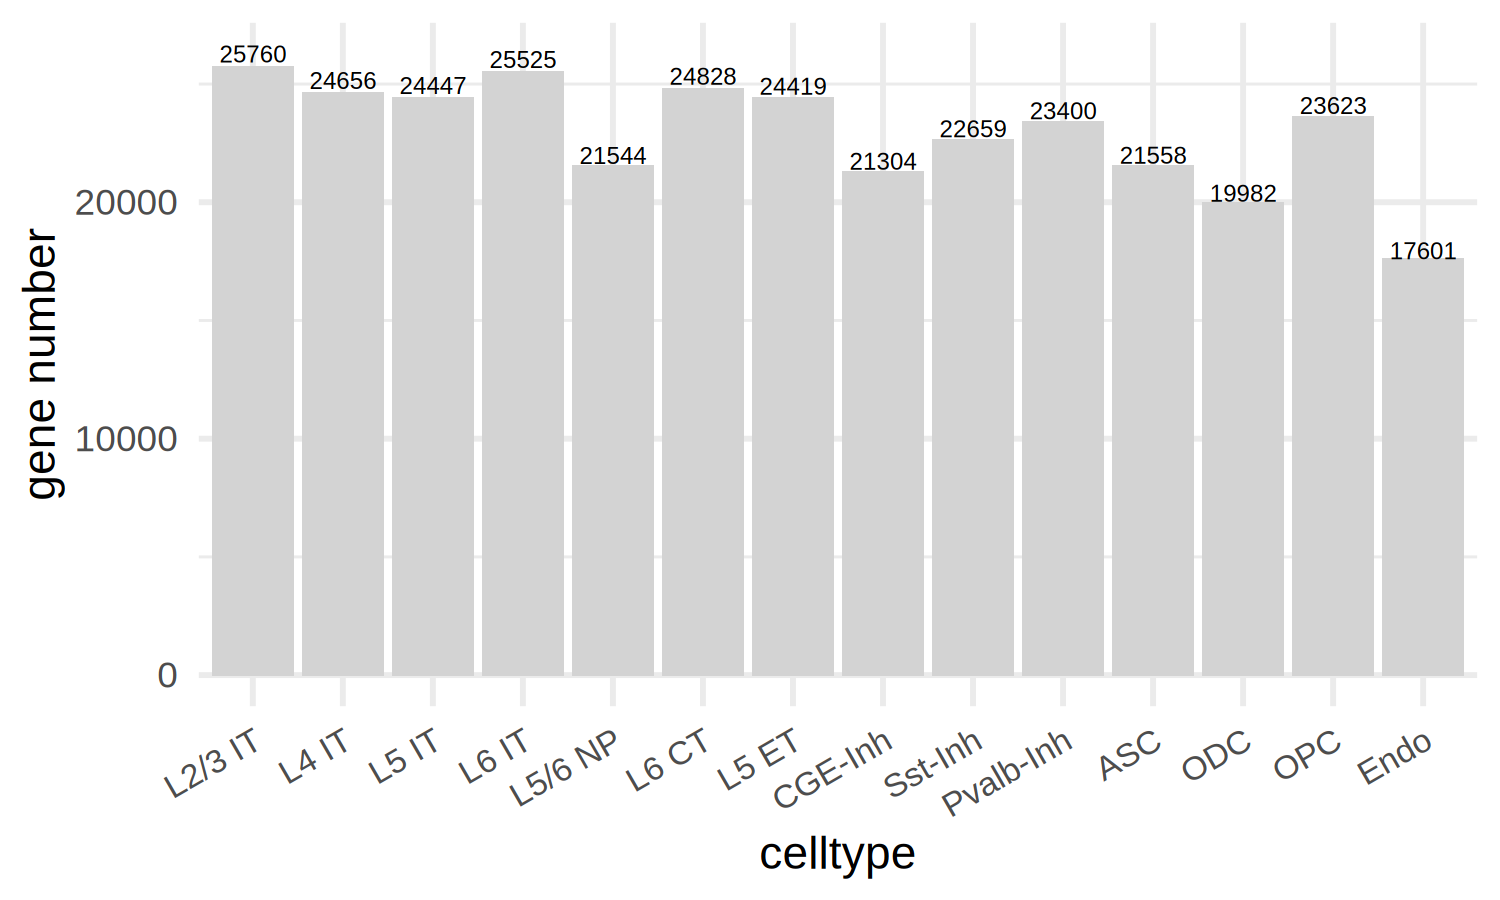

In [45]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)
sapply(pseudo_de,nrow) %>%
as.data.frame() %>%
setNames("gene_num") %>%
mutate(celltype=row.names(.)) %>%
mutate(celltype=factor(celltype,levels=names(pseudo_de))) %>%
ggplot(aes(x=celltype,y=gene_num))+
    geom_bar(stat = "identity",fill="lightgrey")+
    geom_text(aes(label = gene_num),
              position = position_stack(vjust = 1.02),size=2)+
    theme_minimal()+
    theme(axis.text.x = element_text(size=8,angle=30,hjust=1,vjust=1))+
    labs(y="gene number")

In [46]:
saveRDS(pseudo_de,file = "./pseudo_DESeq2_DEG_2.rds")

### save DEGs into files

In [42]:
dir.create(path = "./FC0.3.DEG.list_2")

Warning message in dir.create(path = "./FC0.3.DEG.list_2"):
“'./FC0.3.DEG.list_2' already exists”


In [ ]:
## save all gene list
filename=c('L23-IT','L4-IT','L5-IT','L6-IT','L56-NP','L6-CT','L5-ET','CGE-Inh','Sst-Inh','Pvalb-Inh','ASC','ODC','OPC','Endo')
lapply(seq_len(length(names(pseudo_de))),function(x){
            pseudo_de[[x]] %>%
            write.table(,file=paste0("./FC0.3.DEG.list_2/",filename[x],"_iso_vs_soc_total_gene.xls"),sep="\t",quote=F)
    }  
)

In [ ]:
filename=c('L23-IT','L4-IT','L5-IT','L6-IT','L56-NP','L6-CT','L5-ET','CGE-Inh','Sst-Inh','Pvalb-Inh','ASC','ODC','OPC','Endo')
lapply(seq_len(length(names(pseudo_de))), function(x) {
    if (sum(pseudo_de[[x]]$p_val_adj < 0.05 & abs(pseudo_de[[x]]$avg_log2FC) > 0.3,na.rm = TRUE) > 0) {
        filtered_data <- pseudo_de[[x]] %>%
            filter(p_val_adj < 0.05, abs(avg_log2FC) > 0.3)
        
        write.table(filtered_data, 
                    file = paste0("./FC0.3.DEG.list_2/", filename[x], "_iso_vs_soc_DEG.xls"), 
                    sep = "\t", 
                    quote = FALSE, 
                    row.names = TRUE)
    }
})


## Plot DEG number and cell count

In [50]:
p1 <- 
seu_obj@meta.data %>%
    count(celltype) %>%
    ggplot(aes(x=celltype,y=n))+
    geom_bar(stat = "identity",fill="darkgrey")+
    geom_text(aes(label = n), vjust = 0.5,size=4)+
    labs(x="",y="# of cells")+
    theme_minimal()+
    theme(axis.text.x=element_text(angle=90,hjust=1,color='black'),
         plot.margin = unit(c(0,0,0,0), "cm"))

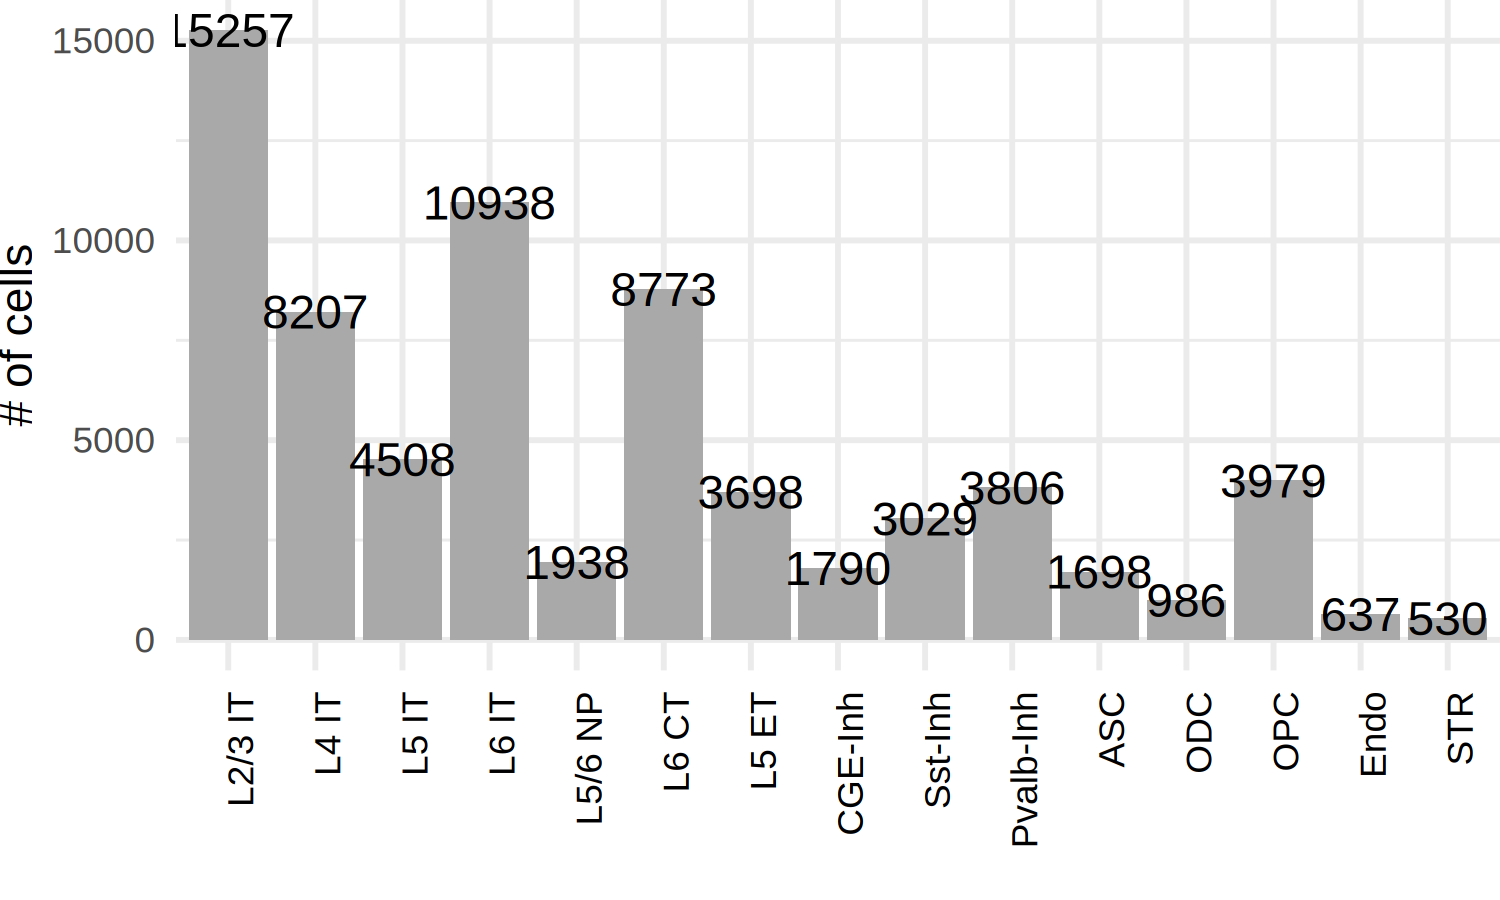

In [51]:
p1

In [52]:
p2 <- 
do.call(rbind,Map(cbind, pseudo_de, new_clumn = names(pseudo_de))) %>%
mutate(diff=case_when(p_val_adj<0.05 & avg_log2FC>0.3 ~ "up",
                     p_val_adj<0.05 & avg_log2FC< (-0.3) ~ "down",
                     .default = "nonsig")
      ) %>%
count(new_clumn,diff) %>%
mutate(plot_y=ifelse(diff=="down",(-1)*n,n)) %>%
filter(new_clumn!="NA",diff!="nonsig") %>%
mutate(new_clumn=factor(new_clumn,levels=levels(seu_obj@meta.data$celltype))) %>%
ggplot(aes(x=new_clumn,y=plot_y,fill=diff))+
geom_bar(stat = "identity")+
geom_hline(yintercept = 0)+
labs(x="",y="# of DEGs",fill="iso/soc")+
geom_text(aes(label = abs(plot_y)), vjust = 0.5,size=5)+
scale_fill_manual(values=c("#85a0ab","#eb9c81"))+
scale_y_continuous(breaks=c(-300,-200,-100,0,100,200),labels=c(300,200,100,0,100,200))+
theme_classic()+
theme(panel.grid = element_blank(),
      axis.text.x = element_text(angle=90,color='black',hjust=1,size=11),
      #axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
     plot.margin = unit(c(0,0,0,0), "cm"))

In [58]:
p2 <- do.call(rbind,Map(cbind, pseudo_de, new_clumn = names(pseudo_de))) %>%
mutate(diff=case_when(p_val_adj<0.05 & avg_log2FC>0.3 ~ "up",
                     p_val_adj<0.05 & avg_log2FC< (-0.3) ~ "down",
                     .default = "nonsig")
      ) %>%
count(new_clumn,diff) %>%
mutate(plot_y=ifelse(diff=="down",(-1)*n,n)) %>%
filter(new_clumn!="NA",diff!="nonsig") %>%
add_row(new_clumn=c("L5/6 NP","Sst-Inh","Pvalb-Inh","ASC","ODC","Endo","STR"),diff="up",n=0,plot_y=0) %>%
mutate(new_clumn=factor(new_clumn,levels=levels(seu_obj@meta.data$celltype))) %>%
ggplot(aes(x=new_clumn,y=plot_y,fill=diff))+
geom_bar(stat = "identity")+
geom_hline(yintercept = 0)+
labs(x="",y="# of DEGs",fill="iso/soc")+
geom_text(aes(label = abs(plot_y)), vjust = 0.5,size=5)+
scale_fill_manual(values=c("#85a0ab","#eb9c81"))+
scale_y_continuous(breaks=c(-300,-200,-100,0,100,200),labels=c(300,200,100,0,100,200))+
theme_classic()+
theme(panel.grid = element_blank(),
      axis.text.x = element_text(angle=90,color='black',hjust=1,size=11),
      #axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
     plot.margin = unit(c(0,0,0,0), "cm"))

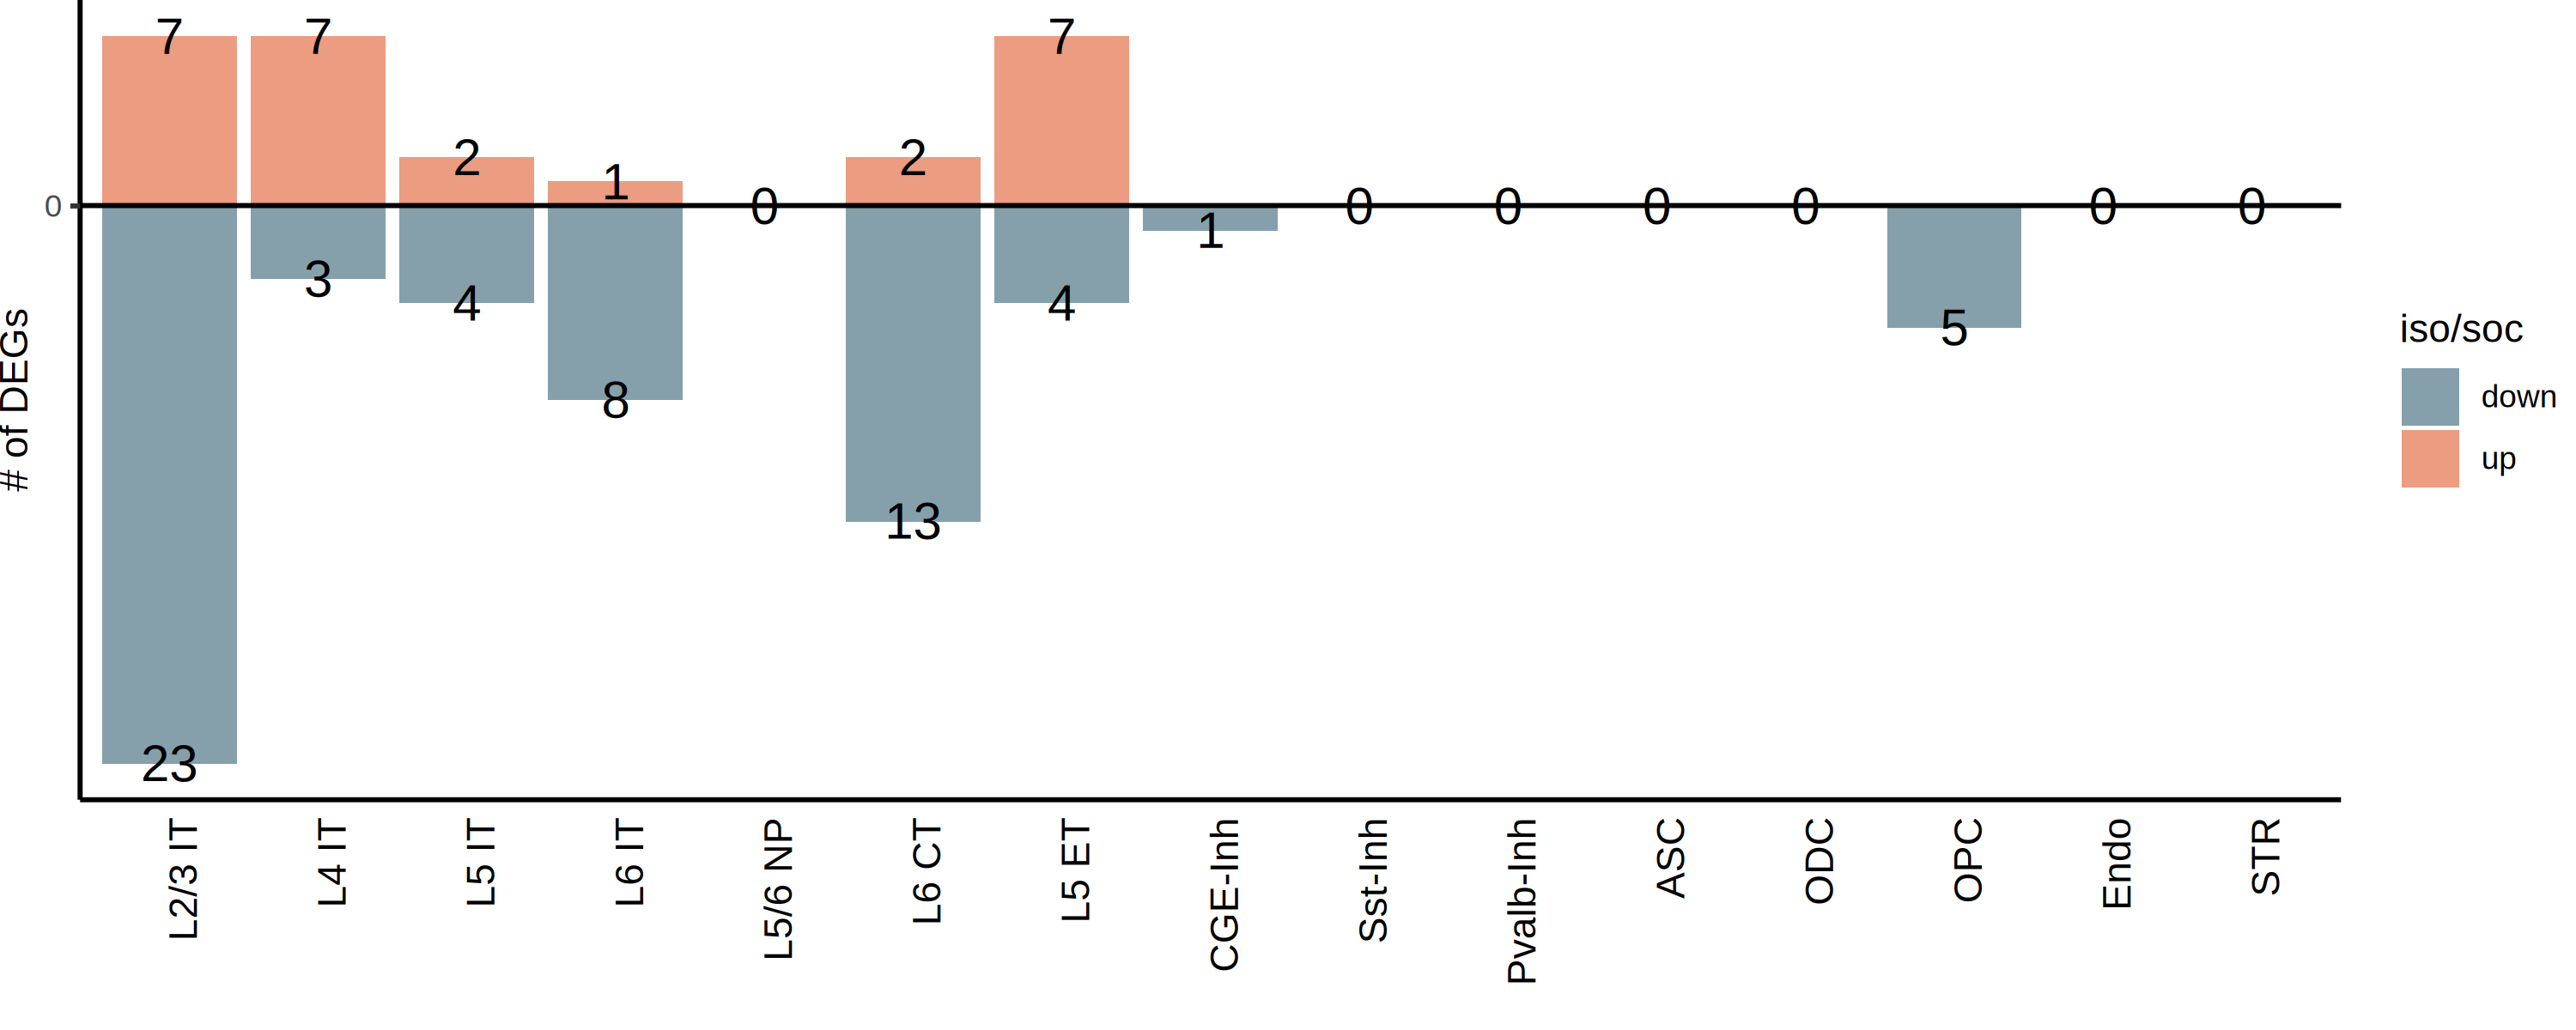

In [59]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
p2

In [60]:
pdf("./DEG_FC0.3_counts_barplot_2.pdf",width=10,height=6)
p2/p1 + plot_layout(heights = c(2, 1))+ plot_annotation(title='threshold: p.adjust<0.05 & |logFC|>0.3')
dev.off()

png 
  2